# 02 — EDA: Target Construction

**Goal:** Build the 41 × 4 × 2 = 328-row panel of log-returns, inspect return distributions, check the predict-zero baseline, and confirm no data-leakage.

**Sections:**
1. Setup & load clean data
2. Compute targets
3. Panel completeness
4. Return distributions
5. Time-series of returns
6. Cross-pair correlations
7. Predict-zero baseline
8. Save targets

## 1. Setup

In [1]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_CLEAN = PROJECT_ROOT / "data-clean"

import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.config import load_config
from src.clean import read_parquet, write_parquet
from src.targets import compute_targets, windows_from_config

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
warnings.filterwarnings("ignore")

cfg = load_config(PROJECT_ROOT / "configs" / "config.yaml")

In [2]:
# Load clean data written by notebook 01
fomc   = read_parquet(DATA_CLEAN / "fomc_metadata.parquet")
bars   = read_parquet(DATA_CLEAN / "intraday_bars.parquet")

# Restore tz-aware timestamp (parquet preserves tz)
print(f"FOMC meetings : {len(fomc)}")
print(f"Bar rows      : {len(bars):,}")
print(f"Sources       : {bars['source'].unique().tolist()}")

INFO: Read 41 rows ← /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/fomc_metadata.parquet
INFO: Read 77025 rows ← /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/intraday_bars.parquet


FOMC meetings : 41
Bar rows      : 77,025
Sources       : ['SPX', 'USDCAD', 'USDEUR', 'USDGBP', 'USDJPY', 'UST10Y', 'UST2Y', 'VIX']


## 2. Compute Targets

In [3]:
windows = windows_from_config(cfg)
print("Windows:", windows)

panel = compute_targets(
    bars=bars,
    fomc_meta=fomc,
    pairs=cfg.pairs,
    windows=windows,
)

print(f"\nPanel shape: {panel.shape}  (max expected: {len(fomc)} × {len(cfg.pairs)} × 2 = {len(fomc)*len(cfg.pairs)*2})")
panel.head(8)

Windows: {'statement': ('14:00', '14:30'), 'digestion': ('14:30', '16:00')}


INFO: Target panel: 328 rows (328 valid, 0 missing / flagged)



Panel shape: (328, 11)  (max expected: 41 × 4 × 2 = 328)


,meeting_id,pair,window,announcement_et,log_ret,abs_ret,direction,n_bars,has_data,price_entry,price_exit
0,20210127,USDCAD,digestion,2021-01-27 14:00:00-05:00,0.001485,0.001485,1,18,True,1.2783,1.2802
1,20210127,USDCAD,statement,2021-01-27 14:00:00-05:00,0.000862,0.000862,1,6,True,1.2762,1.2773
2,20210127,USDEUR,digestion,2021-01-27 14:00:00-05:00,0.000121,0.000121,1,18,True,0.8261,0.8262
3,20210127,USDEUR,statement,2021-01-27 14:00:00-05:00,0.000606,0.000606,1,6,True,0.8254,0.8259
4,20210127,USDGBP,digestion,2021-01-27 14:00:00-05:00,0.001506,0.001506,1,18,True,0.7299,0.7310
5,20210127,USDGBP,statement,2021-01-27 14:00:00-05:00,0.000411,0.000411,1,6,True,0.7292,0.7295
6,20210127,USDJPY,digestion,2021-01-27 14:00:00-05:00,0.000576,0.000576,1,18,True,104.1200,104.1800
7,20210127,USDJPY,statement,2021-01-27 14:00:00-05:00,0.000096,0.000096,1,6,True,104.1100,104.1200


## 3. Panel Completeness

In [4]:
completeness = panel.groupby(["pair", "window"])["has_data"].agg(["sum", "count"])
completeness.columns = ["n_valid", "n_total"]
completeness["pct_valid"] = (completeness["n_valid"] / completeness["n_total"] * 100).round(1)
print(completeness.to_string())

                  n_valid  n_total  pct_valid
pair   window                                
USDCAD digestion       41       41      100.0
       statement       41       41      100.0
USDEUR digestion       41       41      100.0
       statement       41       41      100.0
USDGBP digestion       41       41      100.0
       statement       41       41      100.0
USDJPY digestion       41       41      100.0
       statement       41       41      100.0


In [5]:
# Show any missing cells
missing = panel[~panel["has_data"]][["meeting_id", "pair", "window", "n_bars"]]
if missing.empty:
    print("✓ No missing target cells")
else:
    print(f"Missing cells ({len(missing)}):")
    print(missing.to_string(index=False))

✓ No missing target cells


## 4. Return Distributions

In [6]:
valid = panel[panel["has_data"]].copy()
valid["log_ret_bps"] = valid["log_ret"] * 10_000  # convert to basis points

print("Log-return summary (bps):")
print(valid.groupby(["pair", "window"])["log_ret_bps"].describe().round(2))

Log-return summary (bps):
                  count  mean    std     min    25%    50%    75%     max
pair   window                                                            
USDCAD digestion   41.0 -2.03  38.92  -78.21 -26.63   0.70  23.16  107.85
       statement   41.0 -0.19   7.20  -14.03  -5.15   0.00   3.62   18.08
USDEUR digestion   41.0 -2.71  47.29  -89.43 -25.50  -8.84  32.47  134.58
       statement   41.0 -1.06   9.47  -27.13  -6.91   0.00   6.06   17.72
USDGBP digestion   41.0 -5.89  50.00 -121.64 -27.74  -8.70  24.11  138.84
       statement   41.0 -0.18   9.17  -23.63  -5.18   1.24   6.03   18.97
USDJPY digestion   41.0 -4.70  46.50  -89.42 -28.18 -11.93  20.81  135.70
       statement   41.0 -1.61  12.37  -36.79  -8.18  -1.30   6.13   21.05


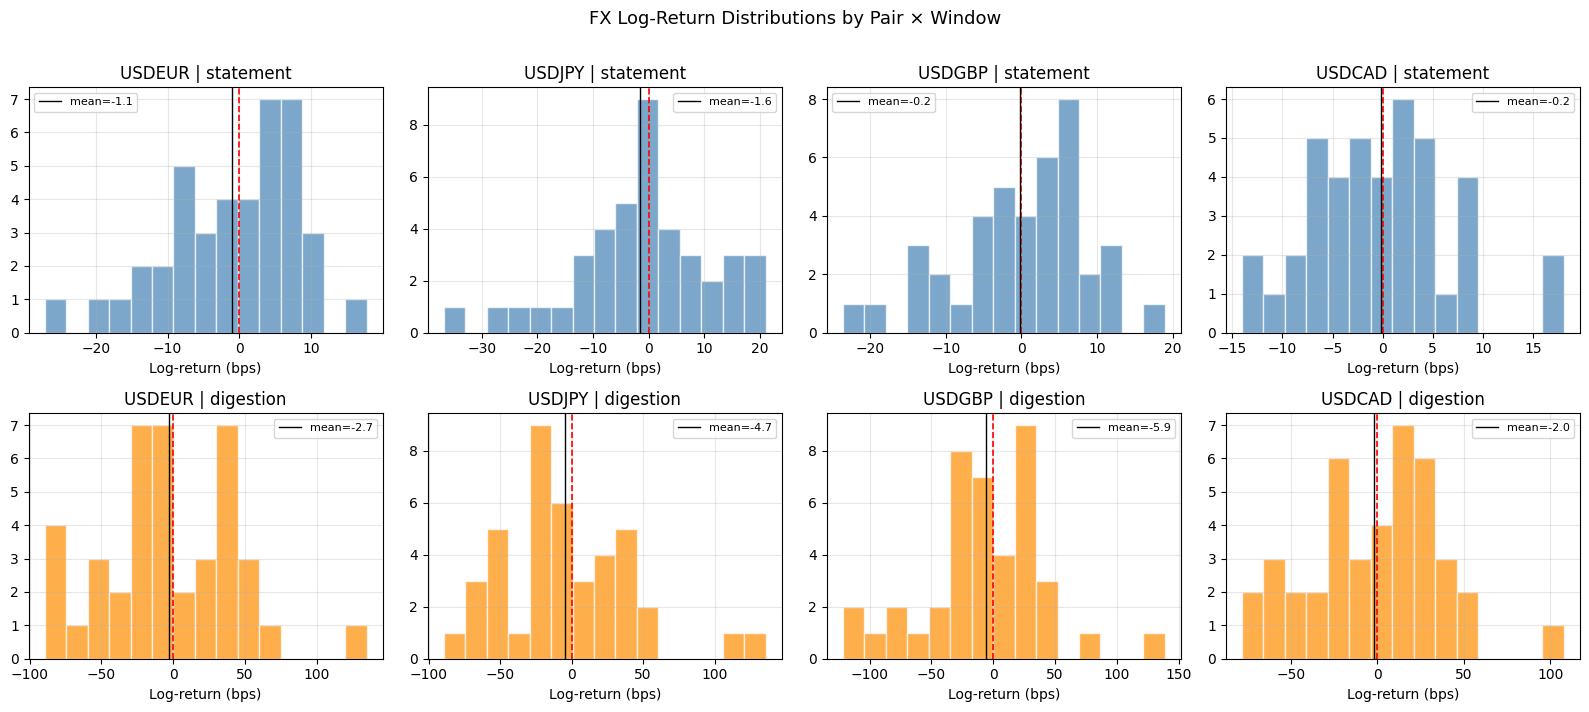

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(16, 7), sharey=False)

pairs = cfg.pairs
window_names = ["statement", "digestion"]
colors = {"statement": "steelblue", "digestion": "darkorange"}

for row_idx, window_name in enumerate(window_names):
    for col_idx, pair in enumerate(pairs):
        ax = axes[row_idx][col_idx]
        data = valid[(valid["pair"] == pair) & (valid["window"] == window_name)]["log_ret_bps"]
        ax.hist(data, bins=15, color=colors[window_name], alpha=0.7, edgecolor="white")
        ax.axvline(0, color="red", lw=1.2, ls="--")
        ax.axvline(data.mean(), color="black", lw=1, ls="-", label=f"mean={data.mean():.1f}")
        ax.set_title(f"{pair} | {window_name}")
        ax.set_xlabel("Log-return (bps)")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

plt.suptitle("FX Log-Return Distributions by Pair × Window", y=1.01, fontsize=13)
plt.tight_layout()
plt.show()

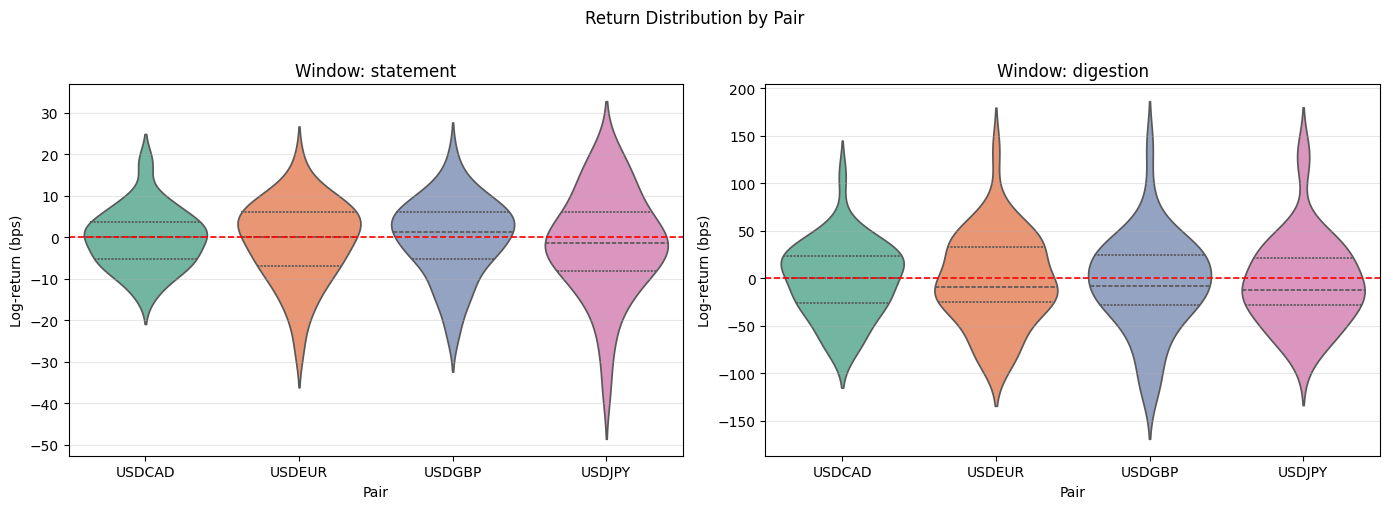

In [8]:
# Violin plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

for ax, window_name in zip(axes, window_names):
    sub = valid[valid["window"] == window_name]
    sns.violinplot(data=sub, x="pair", y="log_ret_bps", ax=ax, palette="Set2", inner="quart")
    ax.axhline(0, color="red", lw=1.2, ls="--")
    ax.set_title(f"Window: {window_name}")
    ax.set_xlabel("Pair")
    ax.set_ylabel("Log-return (bps)")
    ax.grid(True, alpha=0.3, axis="y")

plt.suptitle("Return Distribution by Pair", y=1.01)
plt.tight_layout()
plt.show()

## 5. Time-Series of Returns

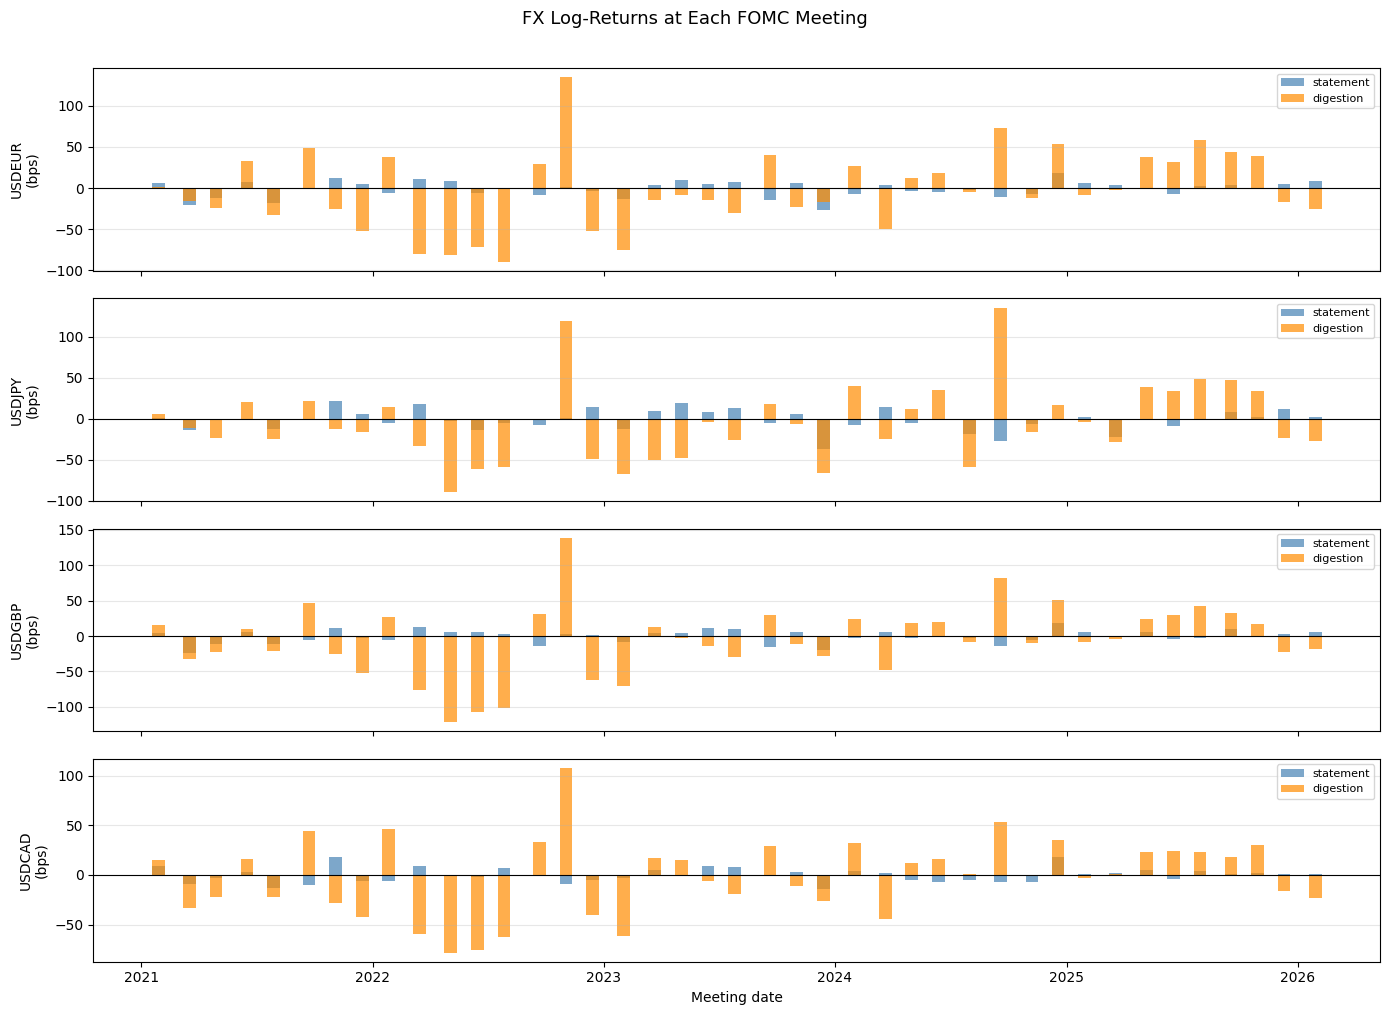

In [9]:
fig, axes = plt.subplots(len(pairs), 1, figsize=(14, 10), sharex=True)

for ax, pair in zip(axes, pairs):
    for window_name, color in colors.items():
        sub = valid[(valid["pair"] == pair) & (valid["window"] == window_name)].sort_values("announcement_et")
        ax.bar(
            sub["announcement_et"],
            sub["log_ret_bps"],
            width=20,
            color=color,
            alpha=0.7,
            label=window_name,
        )
    ax.axhline(0, color="black", lw=0.8)
    ax.set_ylabel(f"{pair}\n(bps)")
    ax.grid(True, alpha=0.3, axis="y")
    ax.legend(loc="upper right", fontsize=8)

axes[-1].set_xlabel("Meeting date")
plt.suptitle("FX Log-Returns at Each FOMC Meeting", y=1.01, fontsize=13)
plt.tight_layout()
plt.show()

## 6. Cross-Pair Correlations

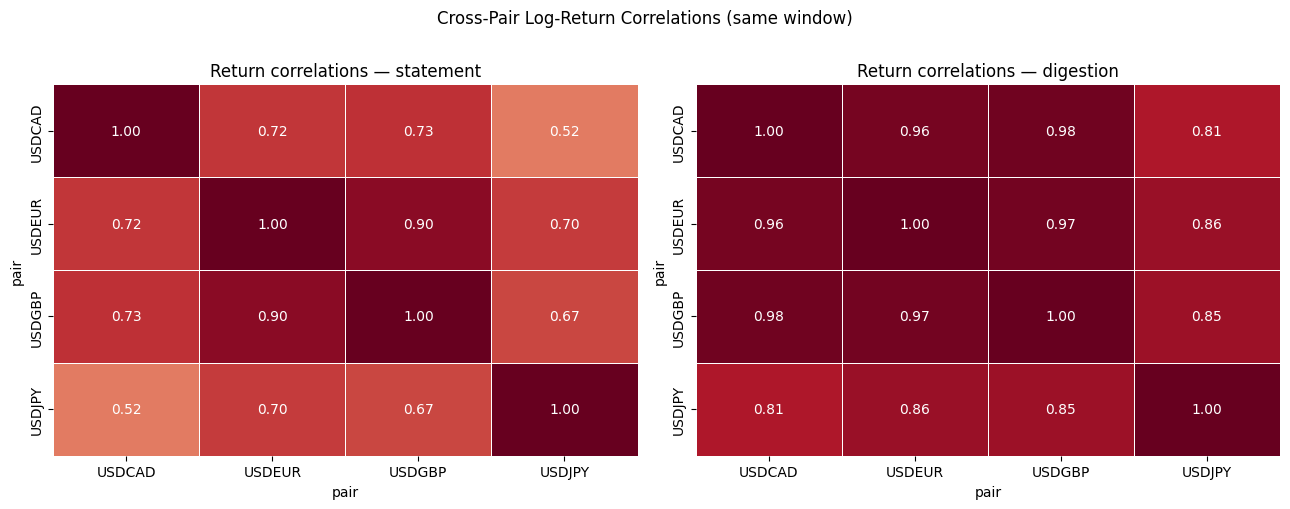

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for ax, window_name in zip(axes, window_names):
    sub = valid[valid["window"] == window_name].copy()
    wide = sub.pivot(index="meeting_id", columns="pair", values="log_ret_bps")
    corr = wide.corr()
    sns.heatmap(
        corr, ax=ax, cmap="RdBu_r", center=0,
        annot=True, fmt=".2f", vmin=-1, vmax=1,
        linewidths=0.5, cbar=False,
    )
    ax.set_title(f"Return correlations — {window_name}")

plt.suptitle("Cross-Pair Log-Return Correlations (same window)", y=1.01)
plt.tight_layout()
plt.show()

## 7. Predict-Zero Baseline

In [11]:
# Predict-zero: MAE = mean(|actual|), directional accuracy = P(actual > 0)
baselines = (
    valid.groupby(["pair", "window"])
    .agg(
        MAE_bps=("log_ret_bps", lambda x: x.abs().mean()),
        RMSE_bps=("log_ret_bps", lambda x: (x**2).mean() ** 0.5),
        dir_acc_pct=("direction", lambda x: (x == 1).mean() * 100),  # P(USD up)
        n=("log_ret_bps", "count"),
    )
    .round(2)
)

print("Predict-zero baseline (MAE, RMSE in bps; dir_acc = % meetings with USD appreciation):")
print(baselines.to_string())

Predict-zero baseline (MAE, RMSE in bps; dir_acc = % meetings with USD appreciation):
                  MAE_bps  RMSE_bps  dir_acc_pct   n
pair   window                                       
USDCAD digestion    31.05     38.50        51.22  41
       statement     5.61      7.11        48.78  41
USDEUR digestion    37.67     46.79        41.46  41
       statement     7.44      9.41        48.78  41
USDGBP digestion    37.73     49.74        43.90  41
       statement     7.16      9.06        51.22  41
USDJPY digestion    36.02     46.17        39.02  41
       statement     9.30     12.32        41.46  41


In [12]:
# Direction balance — ideally close to 50/50 (no systematic bias)
direction_balance = (
    valid.groupby(["pair", "window"])["direction"]
    .value_counts(normalize=True)
    .rename("pct")
    .reset_index()
)
print("\nDirection balance (% of meetings):")
print(direction_balance.pivot(index=["pair", "window"], columns="direction", values="pct").round(3))


Direction balance (% of meetings):
direction            -1      0      1
pair   window                        
USDCAD digestion  0.488    NaN  0.512
       statement  0.463  0.049  0.488
USDEUR digestion  0.585    NaN  0.415
       statement  0.463  0.049  0.488
USDGBP digestion  0.561    NaN  0.439
       statement  0.415  0.073  0.512
USDJPY digestion  0.610    NaN  0.390
       statement  0.585    NaN  0.415


## 8. Save Targets

In [13]:
write_parquet(panel, DATA_CLEAN / "targets.parquet")
print(f"Saved {len(panel)} rows to data-clean/targets.parquet")
print(f"Valid rows: {panel['has_data'].sum()} / {len(panel)}")

INFO: Wrote 328 rows → /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/targets.parquet


Saved 328 rows to data-clean/targets.parquet
Valid rows: 328 / 328


## Summary

| Metric | Value |
|---|---|
| Panel rows (total) | 328 |
| Valid rows | see above |
| Typical MAE (predict-zero) | see baseline table |
| Direction balance | see table above |

**Next:** `03_eda_features.ipynb` — build structured features (rungs 1–3) and check for leakage/missingness.